<a href="https://colab.research.google.com/github/SandeepNarasimhan/Data-Science/blob/master/Multi%20class%20text%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uploading files

In [9]:
!pip install tensorflow_text
!pip install tensorflow_hub

     |████████████████████████████████| 4.9 MB 3.3 MB/s 
     |████████████████████████████████| 462 kB 47.9 MB/s 


In [1]:
from google.colab import files
upload = files.upload()

Saving Corona_NLP_train copy.csv to Corona_NLP_train copy (1).csv


In [2]:
import pandas as pd

df = pd.read_csv('Corona_NLP_train copy.csv')
df.head()


,UserName,ScreenName,Location,TweetAt,text,l1
0,3799,48751,London,16/03/20,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16/03/20,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16/03/20,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16/03/20,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16/03/20,"Me, ready to go at supermarket during the #COV...",Extremely Negative


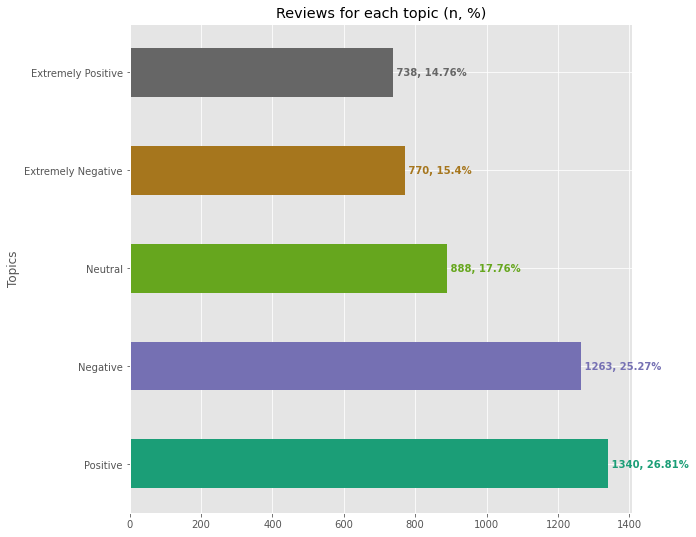

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(df["l1"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df['l1'].value_counts().plot.barh(title="Reviews for each topic (n, %)", 
                                                 ylabel="Topics",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df['l1'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')

In [4]:
df['Labels'] = df['l1'].map({'Positive': 0,
                                            'Negative': 1,
                                            'Neutral': 2,
                                            'Extremely Negative': 3,
                                            'Extremely Positive': 4})

# drop unused column
df = df.drop(['l1',"TweetAt","Location","ScreenName","UserName"], axis=1)

df.head()

,text,Labels
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,0
3,My food stock is not the only one which is emp...,0
4,"Me, ready to go at supermarket during the #COV...",3


In [5]:


from termcolor import colored

def print_rand_example(df, col_name, col_value, chars=180):
  '''print a random review and its translation given a label
  Args:
    - df: input dataframe
    - col_name: column to use as filter (e.g. Label)
    - col_value: value of col_name to use as filter 
    - chars (optional, def:180) max number of characters to display
  '''
  original = df[df[col_name]==col_value].sample()["text"].values[0]
  print(colored("\nOriginal", 'green', attrs=['bold','underline']))
  print(original[0:chars] + "...")


In [6]:
print_rand_example(df, "Labels", 2)


Original
"Everything but the socks, pants and jocks that I was wearing on that particular day." #YouCantAskThat - Tonight 9pm. https://t.co/o58GSj7xqY...


In [7]:

import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.25)

In [10]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)


def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "Once upon a time,"]
)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-9.3632442e-01, -5.5286211e-01, -9.7725952e-01,  9.2556638e-01,
         8.4689319e-01, -3.0760902e-01,  9.5547283e-01,  3.3683184e-01,
        -9.2587173e-01, -9.9999171e-01, -7.9811704e-01,  9.9434537e-01,
         9.8148108e-01,  5.7442111e-01,  9.5589006e-01, -8.2989502e-01,
        -6.5694165e-01, -7.1542567e-01,  5.1411188e-01, -7.8243023e-01,
         7.9021859e-01,  9.9999851e-01, -2.6206955e-01,  3.1068105e-01,
         5.3255588e-01,  9.9929196e-01, -8.8151848e-01,  9.5738846e-01,
         9.7019279e-01,  7.9409653e-01, -7.4366397e-01,  2.4572265e-01,
        -9.9332690e-01, -1.0996654e-01, -9.7059882e-01, -9.9445033e-01,
         5.6484663e-01, -7.6369673e-01,  1.1265296e-01, -1.2759769e-01,
        -9.3876100e-01,  2.9498285e-01,  9.9999070e-01,  1.4474529e-01,
         6.5899944e-01, -3.3324367e-01, -1.0000000e+00,  3.5488468e-01,
        -9.1740525e-01,  9.8076451e-01,  9.6775579e-01,  9.8139834e-01,
         2.995

In [11]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [12]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [13]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
118/118 [==============================] - 245s 2s/step - loss: 1.7189 - accuracy: 0.2353 - balanced_recall: 0.0189 - balanced_precision: 0.0215 - balanced_f1_score: 0.0164 - val_loss: 1.6035 - val_accuracy: 0.2752 - val_balanced_recall: 0.0000e+00 - val_balanced_precision: 0.0000e+00 - val_balanced_f1_score: 0.0000e+00
Epoch 2/20
118/118 [==============================] - 222s 2s/step - loss: 1.6316 - accuracy: 0.2387 - balanced_recall: 1.5408e-04 - balanced_precision: 0.0017 - balanced_f1_score: 2.8249e-04 - val_loss: 1.6168 - val_accuracy: 0.2752 - val_balanced_recall: 0.0000e+00 - val_balanced_precision: 0.0000e+00 - val_balanced_f1_score: 0.0000e+00
Epoch 3/20
118/118 [==============================] - 222s 2s/step - loss: 1.6215 - accuracy: 0.2499 - balanced_recall: 1.5408e-04 - balanced_precision: 8.4746e-04 - balanced_f1_score: 2.6076e-04 - val_loss: 1.6745 - val_accuracy: 0.2544 - val_balanced_recall: 0.0000e+00 - val_balanced_precision: 0.0000e+00 - val_balanced_f1

KeyboardInterrupt: ignored

ValueError: ignored

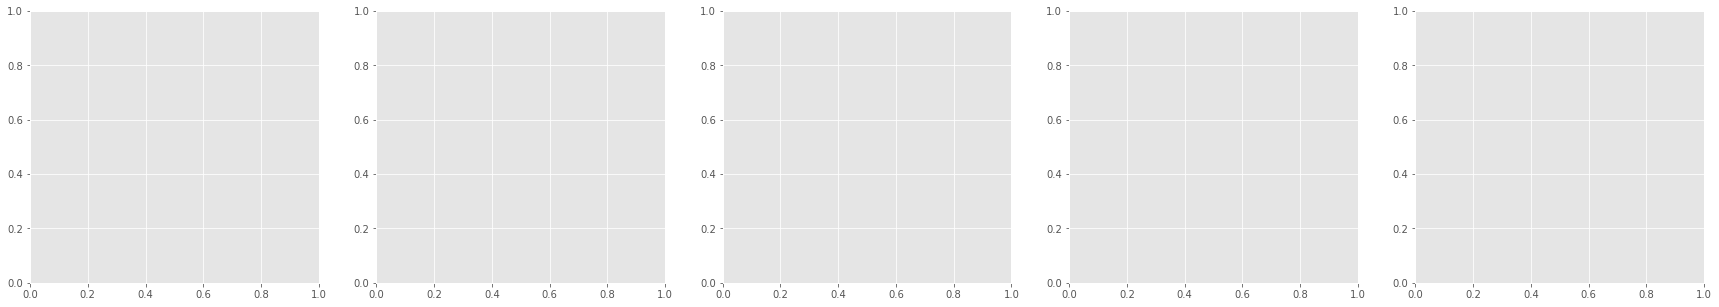

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")